# 09. Transformer가 나오기까지

## 목차
- 1. 들어가며
- 2. Attention의 역사
- 3. Attention Is All You Need!
- 4. Positional Encoding
- 5. Multi-Head Attention
- 6. Position-wise Feed-Forward Networks
- 7. Additional Techniques
- 8. 트랜스포머, 그 후엔

## 1. 들어가며

- 자연어 처리의 꽃이라 불리는 **트랜스포머(Transformer)**에 대해 알아보기
- 최근 자연어 처리 분야에서 혁명적인 발전의 토대가 된 중요한 모델

### 학습 목표
- 트랜스포머 이전의 Attention 기법에 대해 간단하게 복습
- 트랜스포머에 포함된 모듈들을 심층적으로 이해
- 트랜스포머를 발전시키기 위해 적용된 여러 테크닉들 알아보기

## 2. Attention의 역사

- 트래스포머를 본격적으로 다루기 전에 Seq2seq와 Attention 기법 간단하게 복습해 보기
<br>

- **Sequence-to-sequence(Seq2seq)**는 신경망 언어 모델, 특히 기계번역에서 혁신적인 발전 이룩해냄
- 기존의 단일 RNN은 번역에 적합한 구조가 아니었으나 2개의 RNN을 결합한 Encoder-Decoder 구조를 만들어 문맥 전체를 반영한 번역이 가능하게 했음
![RNN.png](./images/RNN.png)
![seq2seq구조.png](./images/seq2seq구조.png)
<br>

- 단순 RNN은 긴 입력에 대한 정보를 학습시키기 어렵기 때문에 Seq2Seq에서는 LSTM을 사용한 Encoder-Decoder 구조를 채택했음
- 논문에서 사용된 표현을 빌리면, Encoder에 **Input** Sequence 'x'를 넣으면 고정된 크긱의 **Representation Vector** 'v'에 모든 정보를 담아 Decoder에게 전달해 주는 구조
- Decoder는 전달받은 'v'를 기반으로 **Output** Sequence 'y'를 생성
- 추가로 'v'는 **컨텍스트 벡터(context vector)**라고 불리기도 함
<br>

- 하지만 고정된 크기의 컨텍스트 벡터를 사용하는 것은 필연적으로 정보의 손실을 야기함
- 특히 문장이 길어지면 더더욱 손실이 커짐
- 단순하게 생각해서 컨텍스트 벡터가 모든 Embedding의 평균이라 하면 3단어를 포함하는 문장과 100단어를 포함하는 문장 중 손실이 일어날 쪽은 당연히 후자
<br>

- 그래서 모든 단어를 같은 비중으로 압축하지 말고, 번역하는 데에 중요한 단어만 큰 비중을 줘서 성능을 높여보자며 Dzmitry Bahadanau가 **Attention**을 제안
- Bahdanau Attention의 시각화를 보고 싶다면 아래 웹페이지 참고
- [Attn: Illustrated Attention](https://eda-ai-lab.tistory.com/157)
<br>

- 매 스텝의 Hidden State 값을 사용하는 것은 제법 효과가 좋았음
- 실제로 그렇게 만들어진 Attention을 히트맵으로 출력하면 의미적으로 유사한 단어들끼리 연결되는 것을 볼 수 있었음
![attention_map.png](./images/attention_map.png)
- [출처: Bahdanau Attention 논문에 포함된 Attention Map](https://arxiv.org/abs/1409.0473)
<br>

- 대각선이 역행하는 'European Economic Area' 부분을 유심히 보시면 같은 의미의 불어'zone economique europeenne'과 의미적으로 유사한 것들끼리 연결된 것을 볼 수 있음
<br>

- Bahdanau Attention이 문제라면 T 스텝에서 Decoder의 Hidden State를 구하기 위해 T-1 스텝의 Hidden State를 사용해야 한다는 것
- 이는 재귀적으로 동작하는 RNN에 역행하는 연산이므로 효율적이지 못함
- 이를 개선하고자 한 것이 **Luong이 제안한 Attention**기법
- [Attention - Luong Attention 개념 정리](https://hcnoh.github.io/2019-01-01-luong-attention)
<br>

- NLP 분야에 Attention 붐이 온 것은 확실했음
- 실제로 우리가 문장을 이해하는 방식과도 굉장히 유사
- 2017년, 이 흐름을 종결하기라도 하려는 듯 **\<Attention Is All You Need>**라는 충격적인 제목의 논문 등장

## 3. Attention Is All You Need!

- **\<Attention Is All You Need>** 논문의 서론의 한 구절 살펴보기
> We propose a new simple network architecture, the **Transformer**, based solely on attention mechanisms, **dispensing with recurrence and convolutions entirely.**<br>
> **RNN과 CNN을 완전히 배제**하고 Attention 메커니즘에만 기반을 둔 새롭고 단순한 구조, **Transformer**를 제안
<br>

- CNN은 자연어 처리에 있어서 흔히 사용되지 않기 때문에 그럴 수 있다고 하지만 RNN은 고안된 배경이 애초에 언어를 모델링 하기 위함이었음
- 그간 RNN은 많은 발전을 거듭했지만 그럼에도 고질병인 **기울기 소실(Vanishing Gradient)**은 완벽히 해결되지 않았음
- 그럼에도 문장 데이터의 순차적인 특성을 유지하기 위해 사용이 필연적이라 생각했음(일종의 고정관념)
<br>

- 심지어 순차적으로 계산한다는 특성은 양날의 검이었음
- 그 특성 때문에 **병렬 처리가 불가능하다**는 것은 큰 문제점이었음
- 마땅한 해결책이 없던 와중에 이를 배제할 수 있는 **트랜스포머**
- [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
<br>

- 위 논문에서 저자들은 문장에서 **연속성이라는 개념을 과감히 배제**하였음
- 대신 Attention으로 **각 단어들의 상관관계를 구하는 데 집중**
- 문장을 모델링 한다는 것은 주어진 단어를 보고 모르는 단어에 확률을 할당하는 것
- 연속성이 배제된 채로 문장을 모델링 하다는, 단순히 생각하면 입력으로 '빨간 사과 노란 바나나'가 들어가는 것과 '노란 사과 빨간 바나나'가 들어가는 것이 동일하게 취급되는 셈
<br>

- RNN처럼 단어 입력을 순차적으로 처리하지도 않으면서 어떻게 문장을 정확히 처리하는지 이해해보기
![트랜스포머구조.png](./images/트랜스포머구조.png)
- 트랜스포머도 엄밀하게는 Seq2seq에서 제안된 Encoder-Decoder 구조를 사용
- 대신 그 안에는 LSTM 대신 다양한 모듈들이 가득 차 있음
- 그리고 Encoder와 Decoder를 여러 개(논문에서는 6개) 쌓아올려 모델을 완성
> Enc-Dec-Enc-Dec-... 구조가 아닌 Enc-Enc-...-Dec-Dec-... 구조
<br>

- 먼저 문장의 연속성을 어떻게 배제할 수 있었는지, 모델의 최하단에 위치한 **Positional Encoding**부터 알아보기

## 4. Positional Encoding

- 이번에 살펴볼 부분은 **Positional Encoding** 부분
![positional_encoding.png](./images/positional_encoding.png)
<br>

- 이전 스텝에서 문장의 연속성을 배제할 경우, '빨간 사과 노란 바나나'와 '노란 사과 빨간 바나나'를 같은 문장으로 간주하게 됨
- Positional Encoding은 그런 불상사를 막기 위한 방법
- 즉, **문장에 연속성을 부여하는 새로운 방법**을 제시한 것
<br>

- 쉽게 말하면 입력이 들어온 순서대로 단어에 표기를 하는 것과 같음
- 예를 들면, '\[빨간 + 1\]\[사과 + 2\] \[노란 + 3\] \[바나나 + 4\]'과 같은 모양새
- 하지만 그렇다고 단어 Embedding에 선형적으로 증가하는 값을 더해줬다간 **후에 데이터의 분포가 엉망**이 될 것

- 문제없이 Position을 나타낼 수 있는 방법엔 어떤 것들이 있을까?
- 아래 웹페이지에서 자세한 내용 확인해보기
- [jeongstudy: positional encoding이란 무엇인가](https://skyjwoo.tistory.com/31)

============================================================================================================================
- Q) 글의 저자가 제시한 Positional Encoding의 2가지 방법과 그 한계는 각각 무엇인가
- 1. 각 단어에 0 ~ 1 사이의 값을 더함. 0을 첫 번째 단어로, 1을 마지막 단어로 함
    -  문장의 길이에 따라 더해지는 값이 가변적. 따라서, 단어간의 거리(Delta)가 일정하지 않음
- 2. 각 단어에 선형적으로 증가하는 정수 더하기
    -  단어 간의 거리(Delta)가 일정해지는 것은 좋지만 범위가 무제한이기 때문에 값이 매우 커질 수 있고 모델이 일반화하기 어려워짐

============================================================================================================================
- Q) Positional Encoding이 만족해야 할 4가지 조건
- 1. 각 Time-step마다 고유의 Encoding 값을 출력해야 함
- 2. 서로 다른 Time-step이라도 같은 거리라면 차이가 일정해야 함
- 3. 순서를 나타내는 값이 특정 범위 내에서 일반화가 가능해야 함
- 4. 같은 위치라면 언제든 같은 값을 출력해야 함

- 저자들이 사용한 Positional Encoding 수식은 아래와 같음
![positional_encoding_수식.png](./images/positional_encoding_수식.png)
<br>

- *pos*는 단어가 위치한 Time-step을 의미하며 *i*는 Encoding 차원의 Index, $d_{model}$은 모델의 Embedding 차원 수
- 이를 **Sinusoid(사인파) Embedding**이라고 칭함
- 이해를 돕기 위해 실제 구현 확인해보기

In [1]:
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

pos = 7
d_model = 4
i = 0

print("Positional Encoding 값:\n", positional_encoding(pos, d_model))

print("")
print("if pos == 0, i == 0: ", np.sin(0 / np.power(10000, 2 * i / d_model)))
print("if pos == 1, i == 0: ", np.sin(1 / np.power(10000, 2 * i / d_model)))
print("if pos == 2, i == 0: ", np.sin(2 / np.power(10000, 2 * i / d_model)))
print("if pos == 3, i == 0: ", np.sin(3 / np.power(10000, 2 * i / d_model)))

print("")
print("if pos == 0, i == 1: ", np.cos(0 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 1, i == 1: ", np.cos(1 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 2, i == 1: ", np.cos(2 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 3, i == 1: ", np.cos(3 / np.power(10000, 2 * i + 1 / d_model)))

Positional Encoding 값:
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]

if pos == 0, i == 0:  0.0
if pos == 1, i == 0:  0.8414709848078965
if pos == 2, i == 0:  0.9092974268256817
if pos == 3, i == 0:  0.1411200080598672

if pos == 0, i == 1:  1.0
if pos == 1, i == 1:  0.9950041652780258
if pos == 2, i == 1:  0.9800665778412416
if pos == 3, i == 1:  0.955336489125606


- 위 예제의 경우, 직접 Positional Encoding의 1번째 열과 2번째 열을 4번째 행까지 구해보는 하드 코딩이 포함되어 있음
- 혹시라도 수식의 각 요소들이 무엇을 의미하는지 와닿지 않는다면 소스 분석하며 이해해 보기
<br>

- 또한, Position 없이 각 Time-step별로 고유하다는 것을 시각화를 통해 확인해보기

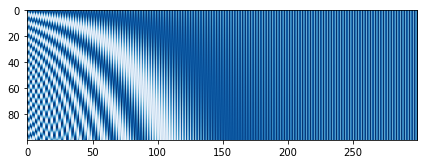

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

- 세로축이 Time-step에 해당하고 가로축이 Word Embedding에 더해질 Position 값
- 한눈에 봐도 각 스텝마다 고유한 값을 가지는 것을 알 수 있음
<br>

- 저자들은 이뿐만 아니라 **Positional Embedding**기법도 제안했음
- 수식적으로 계산한 Position 값이 아니라 Position에 대한 정보를 담은 Embedding 레이어를 선언하여 위치에 대한 정보를 확습할 수 있게 한 것
- 그림으로 표현하면 아래와 같음
![positional_embedding.png](./images/positional_embedding.png)
<br>

- 위와 같은 구조에서 Positional Embedding이 훈련 중 값이 변한다고 하더라도 그것은 **모든 문장에 대해 동일하게 적용**되기에 문제가 되지 않음
- 오히려 Sinusoid Embedding보다 **적합한 값이 학습될 것을 기대**할 수도 있음
<br>

- 하지만 실제로는 두 방법 모두 거의 동일한(+-0.1BLEU)결과를 보였으며, 저자들은 길이가 길어져도 부담이 없는 Sinusoid Embedding을 채택하였음
- Positional Embedding은 문장의 길이만큼 Embedding Table의 크기가 커짐
- Positional Embedding은 추후에 **BERT**라는 모델에 적용되서 좋은 성능 보여줄 예정

## 5. Multi-Head Attention

- 이번에는 트래스포머의 핵심으로 꼽히는 **Multi-Head Attention**에 대해 알아보기
- Positional Embedding이 된 문장으로부터 Attention을 추출하는 부분
![multi_head_attention.png](./images/multi_head_attention.png)
- 위 그림에서 보라색으로 표시된 Masked Multi-Head Attention은 Multi-Head Attention과 동일하지만 **인과 관계 마스킹(Causality Masking)**이라는 과정이 하나 더 추가됨
- 흐름에 따라 자연스럽게 후술할 예정
<br>

- Multi-Head Attention 모듈은 Linear 레이어와 Scaled Dot-Product Attention 레이어로 이루어짐
![multi_head_attention2.png](./images/multi_head_attention2.png)

### Scaled Dot-Product Attention
![scaled_dot_product_attention.png](./images/scaled_dot_product_attention.png)
- 먼저 Scaled Dot-Product Attention에 대해 배워보기
- 트랜스포머 논문 원문을 처음 읽게 될 때 맞닥뜨리게 되는 어려움 중 하나는, 수식도 이해되고 네트워크도 이해할 수 있음에도 불구하고 그 의미가 직관적으로 잘 와닿지 않는다는 점
- 특히 그중에서도 위 그림에 나오는 Q(query), K(key), V(value)가 어떤 의미를 가지고 있는지 특별한 설명이 없다는점
- 이 3가지의 의미는 오히려 후속 연구들을 통해 더욱 구체적으로 밝혀지고 있음
<br>

- 하지만 2017년 시점으로 돌아가서, 이 Scaled Dot-Product Attention도 결국 그때까지 나왔던 attention 개념의 연장선이었음을 떠올려 보기
- 이해를 돕기 위해 이전 시간에 다루었던 Bahdanau attention 개념과 나란히 놓고 비교해 보기
<br>

- 아래 그림의 오른쪽은 지난 시간에 다루었던 전통적인 attention 개념
- seq2seq 인코더-디코더 구조에서 attention이란 바로 디코더의 포지션 *i*에서 바라본 인코더의 context vector $c_i$를 해석하기 위해, 인코더의 각 포지션 *j*에 부여한 가중치
- 이 가중치는 디코더의 state $s_j$와 인코더의 $h_j$사이의 유사도를 위해 계산되었음
<br>

- 원리는 동일함
- 단지 디코더의 state를 Q(query)라고 부르고, 인코더의 state K(key)라고 추상화한 것
- 그래서 Q와 K의 유사도를 dot product로 계산하여 $$ softmax(\frac{QK^T}{\sqrt{d_k}})$$를 어텐션 가중치로 삼고, 이것으로 V(value)를 재해석해 준 것
<br>

- 하나 다른 점은, 인코더 쪽에서 $h_j$ 하나만 존재하던 것이 K와 V 2가지로 분화되었다는 점
![dot_product_attention.png](./images/dot_product_attention.png)
<br>

- 이제 위 그림에서 왼쪽 그림의 Attention(Q, K, V)와 오른쪽 그림의 $c_i$가 실은 같은 형태이며, $$ softmax(\frac{QK^T}{\sqrt{d_k}})$$가 $a_ij$가 같은 역할을 하고 있다는 것이 눈에 들어올 것
<br>

- 아래 웹페이지 설명 참고
- [reniew's blog: Transformer:Attention is all you need](https://reniew.github.io/43/)

====================================================================================================================================
- Q3) Query와 Key를 Dot-Product한 후 Softmax를 취하는 것은 어떤 의미를 가지는가
- 하나의 Query와 모든 Key들 사이의 연관성(유사도)을 계산한 후 그 값을 확률 값으로 만듬. 이는 Query가 어떤 Key와 높은 확률로 연관이 있는지 계산

====================================================================================================================================

- $\frac{1}{\sqrt{d_k}}$: $"Scaled" Dot-Product Attention$

====================================================================================================================================
- Q4) 트랜스포머의 Attention은 위의 식으로 Attention 값을 나눠준다는 것에서 "Scaled" Dot-Product Attention이라고 불림. 이 Scale 과정은 어떤 의미를 가지는가(또는 왜 필요한가?)
- Embedding 차원 수가 깊어지면 깊어질수록 Dot-Product 값은 커지게 되어 Softmax를 거치고 나면 미분 값이 작아지는 현상 나타남. 그 경우를 대비해 Scale 작업이 필요

====================================================================================================================================

- 정리하자면 Scaled Dot-Product Attention은 **Additive(합 연산 기반) Attention**과 **Dot-Product(=Multiplicative, 곱 연산 기반) Attention** 중 후자를 사용한 Attention이고, 차원 수가 깊어짐에 따라 Softmax 값이 작아지는 것을 방지하기 위해 Scale 과정을 포함하였음
- 이 과정을 본떠 **Scaled Dot-Product Attention**이라고 이름이 붙여진 것
<br>

- 다만 Attention 속 Softmax의 성질을 이해하지 못한 상태라면 약간의 찜찜함이 남아있을 수 있음
- 이를 해결하기 위해 간단한 코딩으로 직접 값을 확인해 보기

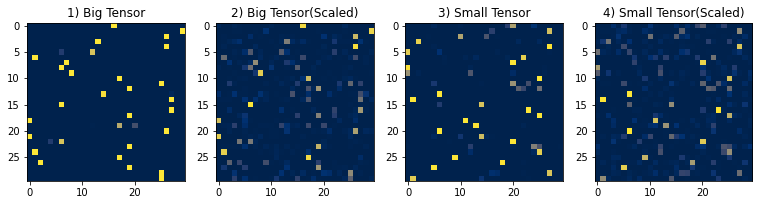

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

length = 30
big_dim = 1024.
small_dim = 10.

big_tensor = make_dot_product_tensor((length, int(big_dim)))
scaled_big_tensor = big_tensor / tf.sqrt(big_dim)
small_tensor = make_dot_product_tensor((length, int(small_dim)))
scaled_small_tensor = small_tensor / tf.sqrt(small_dim)

fig = plt.figure(figsize=(13, 6))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.set_title('1) Big Tensor')
ax2.set_title('2) Big Tensor(Scaled)')
ax3.set_title('3) Small Tensor')
ax4.set_title('4) Small Tensor(Scaled)')

ax1.imshow(tf.nn.softmax(big_tensor, axis=-1).numpy(), cmap='cividis')
ax2.imshow(tf.nn.softmax(scaled_big_tensor, axis=-1).numpy(), cmap='cividis')
ax3.imshow(tf.nn.softmax(small_tensor, axis=-1).numpy(), cmap='cividis')
ax4.imshow(tf.nn.softmax(scaled_small_tensor, axis=-1).numpy(), cmap='cividis')

plt.show()

- 모두 같은 범위인 \[-3, 3\]에서 랜덤 Tensor를 만들어 실제 Attention을 하듯 Dot-Product를 하고, Softmax를 취했음
- 위 히트맵에서 우두운 부분으로는 **미분값(Gradient)**이 흐르기 어렵기 때문에 모델이 넓은 특성을 반영할 수 없게 됨
- 즉, 히트맵이 **선명할수록 모데릉시야기 편협해진다**고 이해
<br>

- 위 시각화를 통해 Embedding이 깊이가 깊을수록 모델이 시야가 편협해지는 문제가 생기고, \[1, 3\], Scale은 그 문제의 훌륭한 해결책임을 확인할 수 있음\[2, 4\]
- 심지어 깊이에 무관하게 일정한 결과를 만들어내므로 어떤 경우에도 적용할 수 있는 훌륭한 Attention 기법이 탄생했음을 알 수 있음 

### 인과 관계 마스킹(Causality Masking)
- Attention 기법 중 **인과 관계 마스킹(Causality Masking)**
<br>

- Sequence-to-sequence 모델을 훈련할 때에 Decoder의 첫 입력으로 '\<start\>' 토큰이 들어갔음
- 그럼 Decoder는 컨텍스트 '벡터로 압축된 입력 문장'rhk '\<start\>' 토큰만을 단서로 첫 번째 단어를 생성해야 함
- 그다음 스텝도 같은 단서에 추가로 방금 Decoder 본인이 생성한 첫 번째 단어를 포함하여 두 번째 단어를 생성
- 이같은 특성을 **자기 회귀(Autoregressive)**라 칭함
- 자기 자신을 입력으로 하여 자기 자신을 예측하는 것
<br>

- 하지만 트래스포머는 모든 단어를 병렬적으로 처리하기에 **자기 회귀적인 특성을 잃어버림**
- 이는 곧 문장을 생성할 수 없다는 의미이고, 쓸모가 없다는 의미
<br>

- 이에 저자들이 자기 회귀적인 특성을 살리기 위해 추가한 것이 바로 **인과 관계 마스킹(Causality Masking)
- 인과 관계 마스킹은 목표하는 문장의 일부를 가려 **인위적으로 연속성을 학습**하게 하는 방법
- 아래 그림을 참고
![causality_masking.png](./images/causality_masking.png)
<br>

- 위와 같은 과정을 거치면 모든 Time-Step에 대한 입력을 1번에 처리하면서 **자기 회귀적인 특성도 유지**하게 됨
- 테스트 시 소스 문장을 Encoder에 전달하고 타겟 문장은 '\<start\>'만 넣더라도 모델이 '\<start\>' 토큰만 보고 문장을 생성한 적(위 그림의 마지막 Step)이 있기 때문에 첫 번째 단어를 생성해낼 수 있고, 생성된 단어는 다시금 입력으로 전달되어 그야말로 **자기 회귀적으로 문장을 생성**하게 됨
<br>

- 이러한 연유로 인과 관계 마스크는 대각항을 포함하지 않는 **삼각 행렬**의 모양새를 갖음
- 입력 문장만을 보고 첫번째 단어를 생성하는 것은 타겟 문장을 모두 가리는 것이 타당하니 대각항을 포함하는 게 맞지만, 그럴 경우 Attention 값을 구하는 과정에서 마지막(혹은 첫 번째)행이 0개 요소에 대해 Softmax를 취하게 되므로 오류를 야기
- 따라서 \<start\> 토큰을 활용해 마스크가 대각항을 포함하지 않는 형태가 되게끔 만든 것
<br>

- (참고)대각항(diagnal entry)이란 행렬에서 행과 열의 지표수가 같은 성분(대각성분) 의미
- 행렬에 대한 개념 복습하라면 [여기](https://sensol2.tistory.com/26) 참고
<br>

- 아래 코드를 통해 이해해 보기

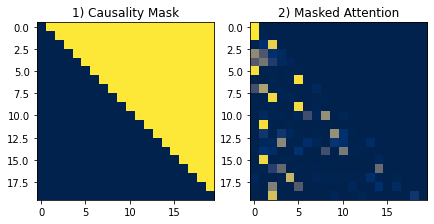

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

- 좌측은 실제 마스크의 형태, 우측은 마스킹이 적용된 Attention
- 마스킹은 **마스킹 할 영역을 -∞**로 채우고 **그 외 영역을 0**으로 채운 배열을 Dot-Product된 값에 더해주는 방식으로 진행됨
- 후에 진행될 Softmax는 큰 값에 높은 확률을 할당하는 함수이므로 -∞로 가득 찬 마스킹 영역에는 무조건 0의 확률을 할당하게 됨

### Multi-Head Attention
![multi_head_attention3.png](./images/multi_head_attention3.png)
- Scaled Dot-Product Attention을 이해하고 나면 정작 Multi-Head Attention 모듈은 간단함
- 일전에 Embedding이 어떤 추상적인 속성을 담고 있다과 배웠음
- Multi-Head Attention은 그 개념을 활용해서 이해를 하면 아주 쉬움
<br>

- '바나나'라는 단어가 512차원의 Embedding을 가진다고 가정
- 그중 64차원은 노란색에 대한 정보를 표현하고, 다른 64차원은 달콤한 맛에 대한 정보를 표현할 것
- 같은 맥락으로 '바나나'의 형태, 가격, 유통기한까지 모두 표현할 수 있음
- 저자들은 '이 모든 정보들을 섞어서 처리하지 말고, 여러 개의 Head로 나누어 처리하면 **Embedding의 다양한 정보를 캐치**할 수 있지 않을까?'라는 아이디어 제시
<br>

![multi_head_attention4.png](./images/multi_head_attention4.png)
- Multi-Head Attention에서 **Head는 주로 8개**를 사용
- Embedding된 10개 단어의 문장이 \[10, 512\]의 형태를 가진다면, Multi-Head Attention은 이를\[10, 8, 64\]로 분할하여 연산
- 각 64차원의 Embedding을 **독립적으로 Attention**한 후, 이를 이어붙여 다시금 \[10, 512\]의 형태로 되돌리며 연산은 끝남
> "쪼개진 64차원이 연관 있는 것들끼리 묶여있을 거란 보장이 있는가?"<br>
- Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 **앞단에 Linear 레이어를 추가**해 주는 것
- Linear 레이어는 데이터를 특정 분포로 매핑 시키는 역할을 해주기 때문에, 설령 단어들의 분포가 제각각이더라도 Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 **적합한 공간으로 Embedding을 매핑**
<br>

![multi_head_attention5.png](./images/multi_head_attention5.png)
- 비슷한 이유로 각각의 Head가 Attention한 값이 균일한 분포를 가질 거란 보장이 없음
- 따라서 모든 Attention 값을 합쳐준 후, **최종적으로 Linear 레이어**를 거치며 비로소 Multi-Head Attention이 마무리가 됨

## 6. Position-wise Feed-Forward Networks

![position_wise_feed_forward_networks.png](./images/position_wise_feed_forward_networks.png)
- Position-wise Feed-Forward Network는 위의 Multi-Head Attention만큼 센세이녈하지는 않음
- 그래서 논문에서도 큰 분량을 차지하지 않는 개념
- 양이 많지 않으니 논문의 구절을 그대로 읽어보기
<br>

![position_wise_feed_forward_networks2.png](./images/position_wise_feed_forward_networks2.png)
- **W**는 Linear 레이어를 의미하고, **max(0, x)** 함수는 활성 함수 ReLU
- 예를 들어 10단어로 이루어진 Attention된 문장 \[10, 512\]를 \[10, 2048\] 공간으로 매핑, 활성함수를 적용한 후 다시 \[10, 512\] 공간으로 되돌리는 것
- 아래 그림을 통해 'Position-wise Feed-Forward Networks'를 쉽게 설명한 글 확인
- [Attention is all you need paper 뽀개기](https://pozalabs.github.io/transformer/)

====================================================================================================================================
- Q5. FFN 앞에 Position-Wise라는 수식이 붙는 이유
- FFN 연산이 개별 단어(Position)마다 적용되기 때문

====================================================================================================================================

- Q6. (OX문제) 앞서 트랜스포머는 여러 개의 Encoder와 Decoder를 쌓아 완성한다고 했음. 각 레이어의 Position-wise Feed-Forward Networks는 Parameter를 공유하는가
- X. 레이어가 달라지면 다른 Parameter를 사용

====================================================================================================================================

- 설명 중 와닿지 않는 부분을 하나 꼽으라면, 이 모듈이 **커널 사이즈가 1인 Convonlution을 2번 연산한 것과 동일하다고 하는 부분**일 것이라 예상
- 생각보다 이 Linear 연산을 CNN으로 구현한 것도 많고 논문에서도 Convolution으로 언급하는 경우가 종종 있어 지금 이해해두기
![CNN.png](./images/CNN.png)
<br>

- 한 단어를 Embedding 차원만큼의 채널을 갖는 이미지라고 취급한다면 이해가 될 것
- Convolution 레이어의 Weight는 '\[입력 차원 수 X 출력 차원 수 X 커털의 크기\]이므로 커널으 크기가 1이라면 Linear 레이어와 동일한 크기의 Weight를 갖게 됨
<br>

- 최근에는 구글에서 AI를 만드는 AI, AutoML을 활용해 최적의 트래스포머 구조를 찾아내기도 했음
- **진화된 트랜스포머(Evolved Transformer)**는 2층의 레이어 중 아래층 레이어에서 차이를 보이는데, 이때 Linear 레이어를 Convolution 레이어로 표기하는 방식을 택함
- 아래 웹페이지에서 진화된 트랜스포머의 구조 살펴보기
- [Applying AutoML to Transformer Architecures](https://ai.googleblog.com/2019/06/applying-automl-to-transformer.html)

## 7. Additional Techniques

- 트랜스포머의 큰 줄기는 다 배웠음
- 이제 세부 줄기에 대해서 살펴볼 차례
- 세부 줄기가 별거 아닌 것 같아 보여도 성능에 제법 영향을 끼치니 놓치는 부분 없이 잘 숙지하기
![additional_techniques.png](./images/additional_techniques.png)
- 먼저 그림 상으로 배우지 않은 유일한 모둘, 'Add & Norm'에 대해 파헤쳐보기

### Layer Normalization
- Layer Normalization은 데이터를 Feature 차운에서 정규화를 하는 방법
- 또다시 10단어의 Embedding된 문장을 예로 \[10, 512\]에서 512차원 Feature를 정규화하여 **분포를 일정하게 맞춰주는 것**
- Layer Normalization 외에도 다양한 Normalization 방법이 있고, 논외지만 Regularization과 Generalization 등 우리를 헷갈리게 하는 많은 방법들이 있음
- 아랫글에서 모든 개념을 쉽게 정리해 주고 있으니 살펴보기
- [Introduction to Deep Learning Normalization](https://subinium.github.io/introduction-to-normalization/)

====================================================================================================================================
- Q7. 데이터 Feature의 Scale을 직접적으로 조정하는 방법은 무엇인가. 그 이유로 Feature Scaling이라고 불리기도 함
- 정규화(Normalization)

====================================================================================================================================

- Q8. Batch Normalization과 Layer Normalization의 차이점 적어보기
- Batch Normalization은 정규화를 Batch 차원에서 진행하는 것이고, Layer Normalization은 정규화를 Feature 차원에서 진행하는 것

====================================================================================================================================

- Normalization 기법은 비단 트랜스포머뿐만 아니라 어떤 모델에서도 성능 향상을 이끌어낼 수 있는 기법

### Residual Connection
- Skip Connection이라고도 부르는 Residual Connection이 처음 제안된 것은 2015년 **ResNet**이라는 모델과 함께였음
- ResNet은 자연어 처리를 공부하는 입장에서는 다소 낯선 이름
- 컴퓨터 비전에서는 트랜스포머만큼이나 유명한 모델
- 모델 자체를 완벽히 이해할 필요는 없지만, 등장 배경이 된 아이디어는 알아두면 좋음
- 아래 웹페이지에서 내용 확인
- [(7) ResNet (Residual Connection)](https://itrepo.tistory.com/36)

====================================================================================================================================
- Q9. 상식적으로 56개의 레이어를 갖는 네트워크는 20개의 레이어를 갖는 네트워크보다 성능이 좋아야 함. 하지만 그렇지 않음. 그 이유가 무엇인가
- 네크워크가 깊어질 수록, Optimize(Train)하는 것이 어렵기 때문에, 얕은 네트워크가 더 좋은 성능 보이게 됨

====================================================================================================================================

- Q10. Residual Block은 굉장히 간단한 수식으로 표현이 가능함. 수식 적어보기
- $y = f(x) + x$

====================================================================================================================================

- 아주 단순한 아이디어지만, 그 내면에는 깊은 수학적 통찰이 포함되어 있음
- 트랜스포머를 이해하는 데에는 위의 정보만으로도 충분하지만 ResNet의 등장 배경에 대해 더 알아보고 싶다면 아랫글 참고해보기
- [Detailed Guide to Understand and Implement ResNets](https://cv-tricks.com/keras/understand-implement-resnets/)

### Learning Rate Schedular
- 트랜스포머를 훈련하는 데에는 Adam Optimizer를 사용했는데, 특이한 점은 Learning Rate를 수식에 따라 변화시키며 사용했다는 것
- 수식와 아래와 같음
- $lrate = d^{-0.5}_{model}$ ⋅$min (step\_num^{-0.5}, step\_num ⋅ warmup\_steps^{-1.5})$
<br>

- 위 수식을 따르게 되면 $warmup\_steps$까지는 $lrate$가 **선형적으로 증가**하고, 이후에는 $step\_num$에 비례해 **점차 감소하는 모양새**를 보이게 됨

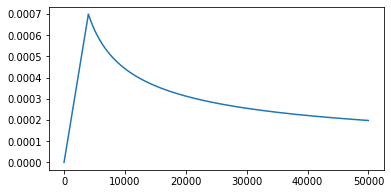

In [5]:
import matplotlib.pyplot as plt
import numpy as np

d_model = 512
warmup_steps = 4000

lrates = []
for step_num in range(1, 50000):
    lrate = (np.power(d_model, -0.5)) * np.min(
        [np.power(step_num, -0.5), step_num * np.power(warmup_steps, -1.5)])
    lrates.append(lrate)

plt.figure(figsize=(6, 3))
plt.plot(lrates)
plt.show()

### Weight Sharing
- 모델의 일부 레이어가 동일한 사이즈의 Weight를 가질 때 종종 등장하는 테크닉
- **하나의 Weight를 2개 이상의 레이어가 동시에 사용**하도록 하는 것
- 대표적으로 언어 모델의 Embedding 레이어와 최종 Linear 레이어가 동일한 사이즈의 Weight를 가짐
- 프로그래밍 개념 중 'Call By Reference'와 비슷한 느낌
<br>

- 가볍게 생각했을 때에는 비효율적인 것으로 보임
- 출력층의 Linear 레이어는 그만의 역할이 있을 것이고 Embedding 레이어 또한 그럴 것인데, 둘을 서로 엮어버리면 이도 저도 아닐 것 같은 느낌이 듬
- 하지만 앞서 ResNet이 증명한 것처럼 **많은 Weight가 곧 성능으로 이어지지 않고,**외려 **Optimazation에서 불리한 경향**을 보인다는 것을 생각하면 이해가 갈 것
<br>

- 실제로 Weight Sharing은 튜닝해야 할 파라미터 수가 감소하기 때문에 학습에 더 유리하며 자체적으로 Regularization 되는 효과도 있음
- 유연성이 제한되어 과적합을 피하기 용이해짐

## 8. 트랜스포머, 그 후엔

- 트랜스포머가 NLP의 꽃이라는 것은 학계의 수많은 관련 논문들이 증명
- 이번에는 트랜스포머를 기반으로 발전한 큰 줄기들을 간단하게 소개
<br>

- 가장 먼저 등장한 것은 **BERT**와 **GPT**
- 두 모델 다 엄청난 양의 데이터를 기반으로 훈련되어 경이로운 성능을 보여줌
- 이들을 잘 소개한 글을 아래에 첨부
- [BERT와 GPT](https://ratsgo.github.io/nlpbook/docs/language_model/bert_gpt/#gpt)

====================================================================================================================================
- Q11. GPT와 BERT의 차이점에 대해 3가지 적어보기
- 1. GPT는 단방향 Attention을 사용하지만 BERT는 양방향 Attention을 사용
- GPT는 트랜스포머에서 디코더(decoder)만 사용하고 BERT는 인코더(encoder)만 사용
- GPT는 문장을 생성할 수 있지만 BERT는 문장의 의미를 추출하는 데 강점을 가지고 있음

====================================================================================================================================

- 트랜스포머는 'max_sequence_length'를 512에서 1024 정도로만 사용
- 그래서 초기에는 주로 몇 개 문장 단위의 번역 작업에 활용되었음
- **문단의 문맥을 파악하는** 수준까지의 보다 긴 입력 길이를 처리할 수 있도록, 기존의 트랜스포머에 Recurrence라는 개념을 추가한 **Transformer-XL**이 제안되기도 했음
- 간단한 이해를 위해 아래의 글 참고
- [Transformer-XL 자료 정리 및 설명요약](https://comeng.tistory.com/entry/Transformer-XL-%EC%9E%90%EB%A3%8C%EC%A0%95%EB%A6%AC-%EB%B0%8F-%EC%84%A4%EB%AA%85%EC%9A%94%EC%95%BD)
<br>

- 지금에 이르러서는 모델 성능이 극대화되어 성능을 높이고자 하는 연구보단 연산량을 줄이고자 하는 연구가 늘고 있음
- **Reformer**는 트랜스포머를 **연산랑 측면에서 혁신적으로 개선**한 모델
- 아래 글을 참고
- [Reformer: 효율적인 트랜스포머](https://brunch.co.kr/@synabreu/31)
<br>

- 이 흐름에서 등장한 재미있는 아이디어 중 하나는 "Multi-Head Attention에서 모든 Head가 과연 필요한가?"라는 주장
- 시야를 넓히기 위해 아래의 글들 참고해보기
- [월간 자연어 처리 - MHA](https://www.facebook.com/permalink.php?story_fbid=156092245822648&id=111809756917564)
- [(논문리뷰) Are Sixteen Heads Really Better than One?](https://littlefoxdiary.tistory.com/m/66?category=847374)
<br>

- 이 외에도 **XLNet, ELECTRA, RoBERTa, GPT-3등**의 다양한 것들이 있음
- 위에 소기한 큰 줄기 중 관심이 가는 부분의 경우, 그쪽으로 파생된 모델들을 차근차근 훑어가는 것도 좋은 공부가 될 것